In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out).reshape(V.shape[0], V.shape[1]) #(batch*50000,1)
        
        return lin_out



In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda:1")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_dend_interact_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/scratch/yjk27/CA1_clust4-60_AP/diff_pred/V_diff_pred_0.2ms.npy").reshape(-1,batch_length)
V = np.load("/scratch/yjk27/CA1_clust4-60/hand/gru_dend_s5_h20_Vall.npy").reshape(-1, batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 50000, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

7601


In [6]:
#model.load_state_dict(torch.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V.pt",
                     #map_location=device))

In [7]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = torch.mean((S_out - batch_S) ** 2)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = torch.mean((S_test - test_S_out) ** 2)
        test_var_exp = explained_variance_score(S_test.flatten().cpu().detach().numpy(),
                                                test_S_out.flatten().cpu().detach().numpy())
        
        score_list.append(test_loss.item())
        print(i, test_loss.item(), test_var_exp)

<ipython-input-7-5c73ecaa3ca6>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 9.884455680847168 -0.0013865232467651367
49 9.642523765563965 0.02037733793258667
99 9.600447654724121 0.0246543288230896
149 9.557196617126465 0.02902895212173462
199 9.514167785644531 0.033409178256988525
249 9.414007186889648 0.04361414909362793
299 9.31356430053711 0.05408596992492676
349 9.262441635131836 0.058973848819732666
399 9.225895881652832 0.06270408630371094
449 9.264469146728516 0.058917462825775146
499 9.197467803955078 0.06559336185455322
549 9.181167602539062 0.0672311782836914
599 9.205381393432617 0.06480824947357178
649 9.139289855957031 0.07148492336273193
699 9.124885559082031 0.07297313213348389
749 9.099231719970703 0.07558786869049072
799 9.133679389953613 0.07218271493911743
849 9.07190990447998 0.07833033800125122
899 9.108365058898926 0.07462847232818604
949 9.028038024902344 0.08278989791870117
999 9.076166152954102 0.07806581258773804
1049 9.032246589660645 0.0823674201965332
1099 9.023303985595703 0.08329468965530396
1149 9.029574394226074 0.0826340913

9649 8.627867698669434 0.1234511137008667
9699 8.585597038269043 0.12774789333343506
9749 8.606325149536133 0.12563270330429077
9799 8.568543434143066 0.12948161363601685
9849 8.608050346374512 0.12545615434646606
9899 8.569999694824219 0.12932205200195312
9949 8.563586235046387 0.13003253936767578
9999 8.544366836547852 0.13192874193191528


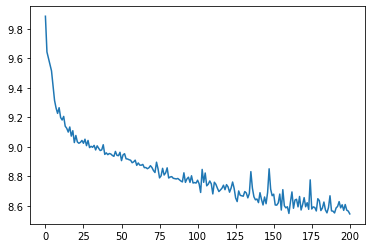

In [8]:
plt.plot(np.asarray(score_list)[:])


tensor(32.6640, device='cuda:1', grad_fn=<MaxBackward1>)


(23000.0, 28000.0)

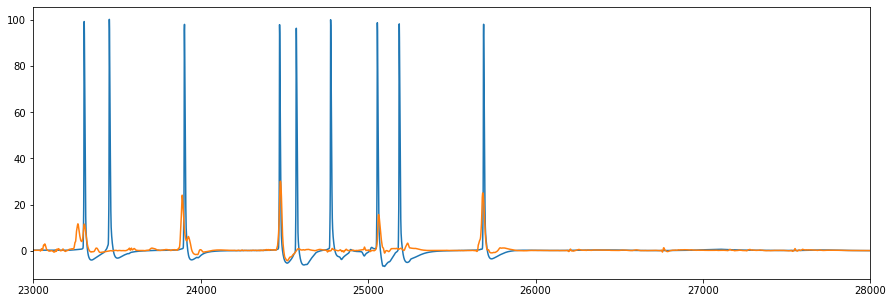

In [9]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[0].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))
plt.xlim(23000,28000)

In [12]:
test_S_out = test_S_out.cpu().detach().numpy()
test_S_out_next = np.zeros_like(test_S_out)
test_S_out_next[:,:-1] = test_S_out[:,1:]
test_S_out_thresh = np.zeros_like(test_S_out)

thresh = 15

for i in range(test_S_out.shape[0]):
    idx = np.where((test_S_out[i] < thresh) & (test_S_out_next[i] >= thresh))[0]
    test_S_out_thresh[i][idx] = 1

In [11]:
print(np.sum(test_S_out_thresh))

167.0


In [13]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_clust4-60_AP/diff_pred/gru_l20_h40_0.2ms_V_dend_interact.pt")

In [14]:
#np.save("/scratch/yjk27/CA1_clust4-60_AP/diff_pred/gru_l20_h40_0.2ms_test_V_dend_interact.npy", test_S_out)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/diff_pred/gru_l20_h40_0.2ms_test_S_dend_interact.npy", test_S_out_thresh)